In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import joblib

In [3]:
#  Load the dataset
data = pd.read_csv('loan_prediction.csv')

In [4]:
#  Check the last 5 rows of the dataset
print(data.tail())

      Loan_ID  Gender Married Dependents Education Self_Employed  \
609  LP002978  Female      No          0  Graduate            No   
610  LP002979    Male     Yes         3+  Graduate            No   
611  LP002983    Male     Yes          1  Graduate            No   
612  LP002984    Male     Yes          2  Graduate            No   
613  LP002990  Female      No          0  Graduate           Yes   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
609             2900                0.0        71.0             360.0   
610             4106                0.0        40.0             180.0   
611             8072              240.0       253.0             360.0   
612             7583                0.0       187.0             360.0   
613             4583                0.0       133.0             360.0   

     Credit_History Property_Area Loan_Status  
609             1.0         Rural           Y  
610             1.0         Rural           Y  
611     

In [5]:
#  Find the shape of the dataset
print("Number of Rows:", data.shape[0])
print("Number of Columns:", data.shape[1])

Number of Rows: 614
Number of Columns: 13


In [6]:

#  Get information about the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None


In [7]:
#  Check for null values
print(data.isnull().sum())
print(data.isnull().sum() * 100 / len(data))

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Loan_ID              0.000000
Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64


In [8]:
#  Handling missing values
data = data.drop('Loan_ID', axis=1)
columns = ['Gender', 'Dependents', 'LoanAmount', 'Loan_Amount_Term']
data = data.dropna(subset=columns)
data['Self_Employed'] = data['Self_Employed'].fillna(data['Self_Employed'].mode()[0])
data['Credit_History'] = data['Credit_History'].fillna(data['Credit_History'].mode()[0])

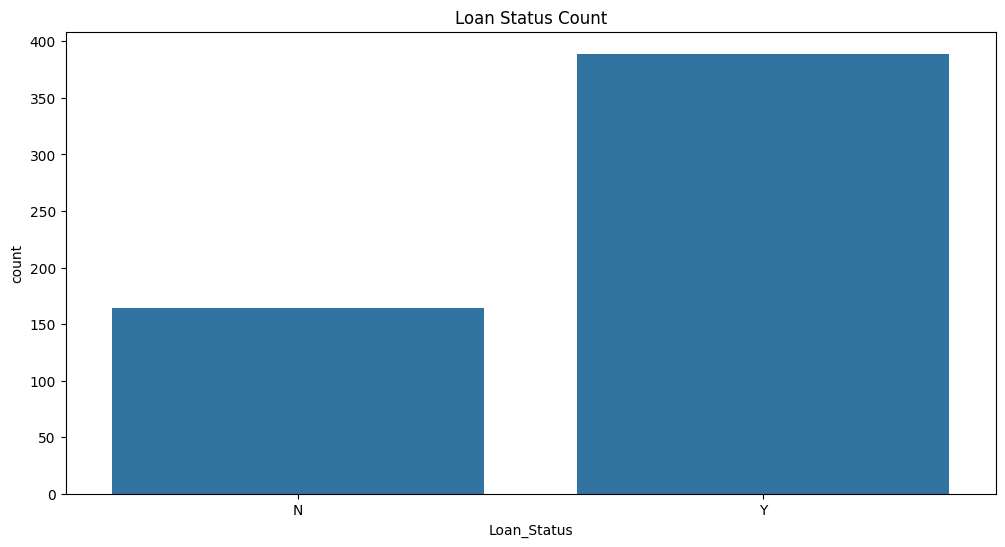

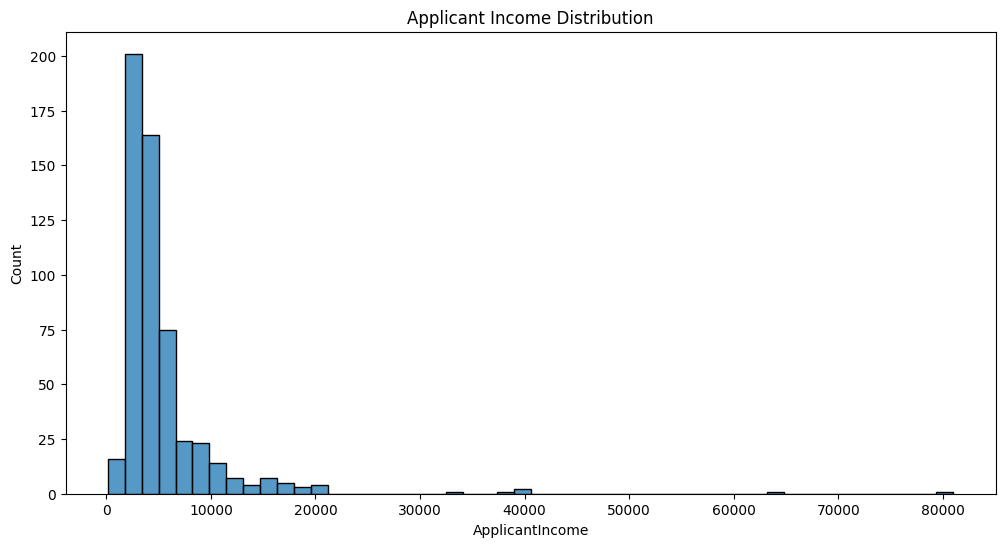

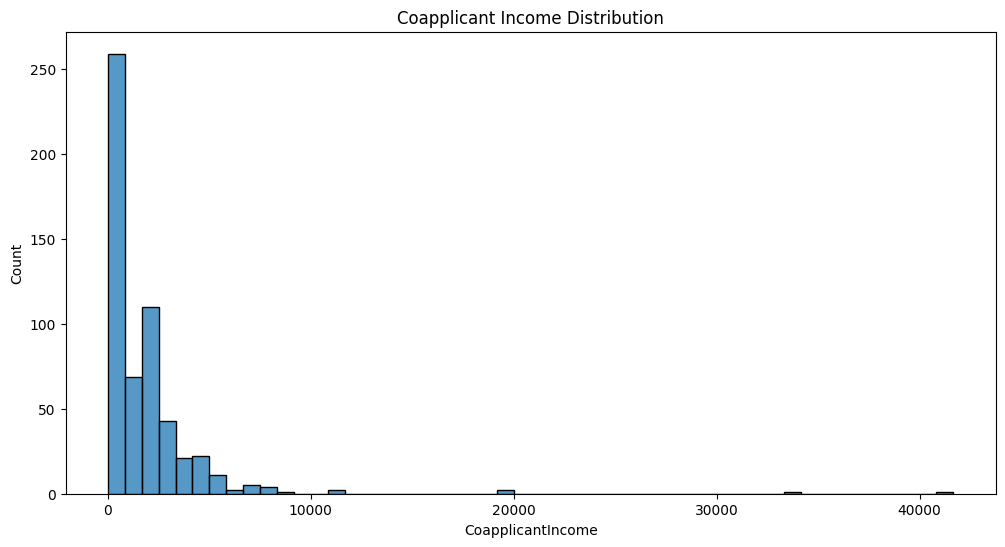

In [9]:
#  EDA
plt.figure(figsize=(12,6))
sns.countplot(x='Loan_Status', data=data)
plt.title('Loan Status Count')
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(data['ApplicantIncome'], bins=50)
plt.title('Applicant Income Distribution')
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(data['CoapplicantIncome'], bins=50)
plt.title('Coapplicant Income Distribution')
plt.show()

In [10]:
#  Handling categorical columns
data['Dependents'] = data['Dependents'].replace(to_replace="3+", value='4')
data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0}).astype('int')
data['Married'] = data['Married'].map({'Yes': 1, 'No': 0}).astype('int')
data['Education'] = data['Education'].map({'Graduate': 1, 'Not Graduate': 0}).astype('int')
data['Self_Employed'] = data['Self_Employed'].map({'Yes': 1, 'No': 0}).astype('int')
data['Property_Area'] = data['Property_Area'].map({'Rural': 0, 'Semiurban': 2, 'Urban': 3}).astype('int')
data['Loan_Status'] = data['Loan_Status'].map({'Y': 1, 'N': 0}).astype('int')

In [10]:

#  Store feature matrix in X and response (target) in vector Y
X = data.drop('Loan_Status', axis=1)
Y = data['Loan_Status']

In [11]:

#  Feature scaling
scaler = StandardScaler()
cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
X[cols] = scaler.fit_transform(X[cols])

In [12]:
#  Split the dataset into the training set and test set & apply K-Fold Cross Validation
model_df = {}

def model_val(model, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    print(f"{model} accuracy is {accuracy_score(Y_test, Y_pred)}")

    score = cross_val_score(model, X, Y, cv=5)
    print(f"{model} Avg cross val score is {np.mean(score)}")
    model_df[model] = round(np.mean(score) * 100, 2)

# 11. Logistic Regression
model = LogisticRegression()
model_val(model, X, Y)

LogisticRegression() accuracy is 0.8018018018018018
LogisticRegression() Avg cross val score is 0.8011466011466013


In [13]:
#  SVC
svc_grid = {'C': [0.25, 0.50, 0.75, 1], "kernel": ["linear"]}
rs_svc = RandomizedSearchCV(SVC(), param_distributions=svc_grid, cv=5, n_iter=4, verbose=True)
rs_svc.fit(X, Y)
print("Best score for SVC:", rs_svc.best_score_)
print("Best parameters for SVC:", rs_svc.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best score for SVC: 0.8066011466011467
Best parameters for SVC: {'kernel': 'linear', 'C': 0.25}


In [14]:
#  Decision Tree Classifier
model = DecisionTreeClassifier()
model_val(model, X, Y)

DecisionTreeClassifier() accuracy is 0.7117117117117117
DecisionTreeClassifier() Avg cross val score is 0.7052088452088452


In [15]:
#  Random Forest Classifier
rf_grid = {'n_estimators': np.arange(10, 1000, 10),
           'max_features': ['sqrt', 'log2', 1, 0.5],
           'max_depth': [None, 3, 5, 10, 20, 30],
           'min_samples_split': [2, 5, 20, 50, 100],
           'min_samples_leaf': [1, 2, 5, 10]}
rs_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=rf_grid, cv=5, n_iter=20, verbose=True)
rs_rf.fit(X, Y)
print("Best score for Random Forest Classifier:", rs_rf.best_score_)
print("Best parameters for Random Forest Classifier:", rs_rf.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best score for Random Forest Classifier: 0.8084193284193285
Best parameters for Random Forest Classifier: {'n_estimators': 370, 'min_samples_split': 100, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}


In [16]:

#  Gradient Boosting Classifier
model = GradientBoostingClassifier()
model_val(model, X, Y)

GradientBoostingClassifier() accuracy is 0.7747747747747747
GradientBoostingClassifier() Avg cross val score is 0.7775921375921376


In [17]:
#  Save the model
rf = RandomForestClassifier(n_estimators=660, min_samples_split=50, min_samples_leaf=1,
                             max_features='sqrt', max_depth=30)
rf.fit(X, Y)
joblib.dump(rf, 'loan_status_predict')

['loan_status_predict']

In [18]:
# Load the model
model = joblib.load('loan_status_predict')

In [22]:
# Get user input for loan prediction
gender = int(input("Enter Gender (1 for Male, 0 for Female): "))
married = int(input("Are you Married? (1 for Yes, 0 for No): "))
dependents = int(input("Enter Number of Dependents: "))
education = int(input("Are you Graduate? (1 for Yes, 0 for No): "))
self_employed = int(input("Are you Self Employed? (1 for Yes, 0 for No): "))
applicant_income = float(input("Enter Applicant's Income: "))
coapplicant_income = float(input("Enter Coapplicant's Income: "))
loan_amount = float(input("Enter Loan Amount: "))
loan_amount_term = float(input("Enter Loan Amount Term: "))
credit_history = int(input("Enter Credit History (1 for Yes, 0 for No): "))
property_area = int(input("Enter Property Area (0 for Rural, 2 for Semiurban, 3 for Urban): "))

# Predict using the model
df = pd.DataFrame({
    'Gender': gender,
    'Married': married,
    'Dependents': dependents,
    'Education': education,
    'Self_Employed': self_employed,
    'ApplicantIncome': applicant_income,
    'CoapplicantIncome': coapplicant_income,
    'LoanAmount': loan_amount,
    'Loan_Amount_Term': loan_amount_term,
    'Credit_History': credit_history,
    'Property_Area': property_area
}, index=[0])

result = model.predict(df)

# Output prediction
if result == 1:
    print("Congratulations! Your loan application is likely to be approved.")
else:
    print("Sorry, your loan application is likely to be rejected.")



Sorry, your loan application is likely to be rejected.
